In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sdss.metadata import MetaData
from autoencoders.ae import AutoEncoder

meta = MetaData()
%matplotlib inline

In [3]:
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"

meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
scores_directory = (
    f"{meta_data_directory}/bin_04/explanation/256_128_64/latent_12"
)
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}"

wave = np.load(f"{meta_data_directory}/wave.npy")
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
ids = np.load(f"{meta_data_directory}/ids_inputting.npy")

model = AutoEncoder(reload=True, reload_from=f"{model_directory}/{model_id}")

In [4]:
GALAXY_LINES = {
    # EMISSION
    "OII_3726": 3726.040,
    "H_delta_4101": 4101.734,
    "H_gamma_4340": 4340.472,
    "H_beta_4861": 4861.352,
    "OIII_4959": 4958.911,
    "OIII_5006": 5006.843,
    "NII_6548": 6548.041,
    "H_alpha_6562": 6562.787,
    "NII_6583": 6583.461,
    "SII_6716": 6716.440,
    "SII_6730": 6730.812,
    # ABSORPTION
}


def plot_compare():
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, tight_layout=True)

    axs[1, 0].set_xlabel("$\lambda [\AA]$")
    axs[1, 1].set_xlabel("$\lambda [\AA]$")
    axs[0, 0].set_ylabel("Median normalized flux")
    axs[1, 0].set_ylabel("Residual")

    return fig, axs


def plot_residual():
    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        # figsize=(20,12),
        sharex=True,
        tight_layout=True,
    )

    axs[0].set_ylabel("Median normalized flux")
    axs[1].set_ylabel("Residual")
    axs[1].set_xlabel("$\lambda [\AA]$")

    return fig, axs


def compare(spectra_idx):
    observation = spectra[spectra_idx]
    reconstruction = model.reconstruct(observation).reshape(-1)
    residual = np.abs(observation - reconstruction)

    return observation, reconstruction, residual


def specobjid_to_idx(specobjid: int, ids: np.array):
    """Obtain train idx from specobjid"""
    mask = np.where(ids[:, 1] == specobjid, True, False)
    idx = int(ids[mask, 0][0])
    return idx

In [5]:
## Get sets of specobjids of anomalous spectra per score
scores_names = {
    "lp_noRel100": "lp score",
    "lp_filter_250kms_noRel100": "lp score with a 250 kms filter",
    "lp_noRel97": "lp score ignoring 3% of largest residuals",
    "lp_filter_250kms_noRel97": "lp score ignoring 3% of largest residuals with a 250 kms filter",
    "lp_rel100": "lp relative score",
    "lp_filter_250kms_rel100": "lp relative score with a 250 kms filter",
    "lp_rel97": "lp relative score\n ignoring 3% of largest residuals",
    "lp_filter_250kms_rel97": "lp relative score ignoring 3% of largest residuals with a 250 kms filter",
    "mse_noRel100": "MSE score",
    "mse_filter_250kms_noRel100": "MSE score with a 250 kms filter",
    "mse_noRel97": "MSE score ignoring 3% of largest residuals",
    "mse_filter_250kms_noRel97": "MSE score ignoring 3% of largest residuals with a 250 kms filter",
    "mse_rel100": "MSE relative score",
    "mse_filter_250kms_rel100": "MSE relative score with a 250 kms filter",
    "mse_rel97": "MSE relative score\n ignoring 3% of largest residuals",
    "mse_filter_250kms_rel97": "MSE relative score ignoring 3% of largest residuals with a 250 kms filter",
    "mad_noRel100": "MAD score",
    "mad_filter_250kms_noRel100": "MAD score with a 250 kms filter",
    "mad_noRel97": "MAD score ignoring 3% of largest residuals",
    "mad_filter_250kms_noRel97": "MAD score ignoring 3% of largest residuals with a 250 kms filter",
    "mad_rel100": "MAD relative score",
    "mad_filter_250kms_rel100": "MAD relative score with a 250 kms filter",
    "mad_rel97": "MAD relative score\n ignoring 3% of largest residuals",
    "mad_filter_250kms_rel97": "MAD relative score ignoring 3% of largest residuals with a 250 kms filter",
}

In [7]:
df_scores = {}

for score_name in scores_names.keys():

    df_scores[score_name] = pd.read_csv(
        f"{scores_directory}/{score_name}/top_anomalies.csv.gz",
        index_col="specobjid",
    )

## Different ways of residuals

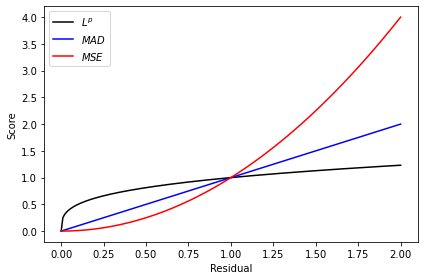

In [8]:
save_to = "/home/edgar/explain-me-why/sections/figures/score"
x = np.linspace(0, 2, 200)
lp = x ** 0.3
mad = x.copy()
mse = x ** 2

fig, ax = plt.subplots(tight_layout=True)

ax.clear()

ax.set_ylabel("Score")
ax.set_xlabel("Residual")

ax.plot(x, lp, c="black", label="$L^p$")
ax.plot(x, mad, c="blue", label="$MAD$")
ax.plot(x, mse, c="red", label="$MSE$")
ax.legend()

fig.savefig(f"{save_to}/pvalues.pdf")

## most normal, most anomalous

In [9]:
score = "mse_noRel100"
normal_rank = 0
anomalous_rank = -1
normal_specobjid = df_scores[score].index[normal_rank]
normal_idx = specobjid_to_idx(normal_specobjid, ids)
anomalous_specobjid = scores_df[score].index[anomalous_rank]
anomalous_idx = specobjid_to_idx(anomalous_specobjid, ids)

[normal_observation, normal_reconstruction, normal_residual] = compare(
    normal_idx
)

[
    anomalous_observation,
    anomalous_reconstruction,
    anomalous_residual,
] = compare(anomalous_idx)

fig, axs = plot_compare()

for axs_a in axs:
    for ax in axs_a:
        ax.clear()

axs[0, 0].plot(wave, normal_observation, c="black", label="observation")
axs[0, 0].plot(wave, normal_reconstruction, c="red", label="reconstruction")
axs[0, 0].legend()
axs[1, 0].plot(wave, normal_residual, c="black")

axs[0, 1].plot(wave, anomalous_observation, c="black", label="observation")
axs[0, 1].plot(wave, anomalous_reconstruction, c="red", label="reconstruction")
axs[0, 1].legend()
axs[1, 1].plot(wave, anomalous_residual, c="black")

KeyError: 'mse_noRel100'

KeyboardInterrupt: 

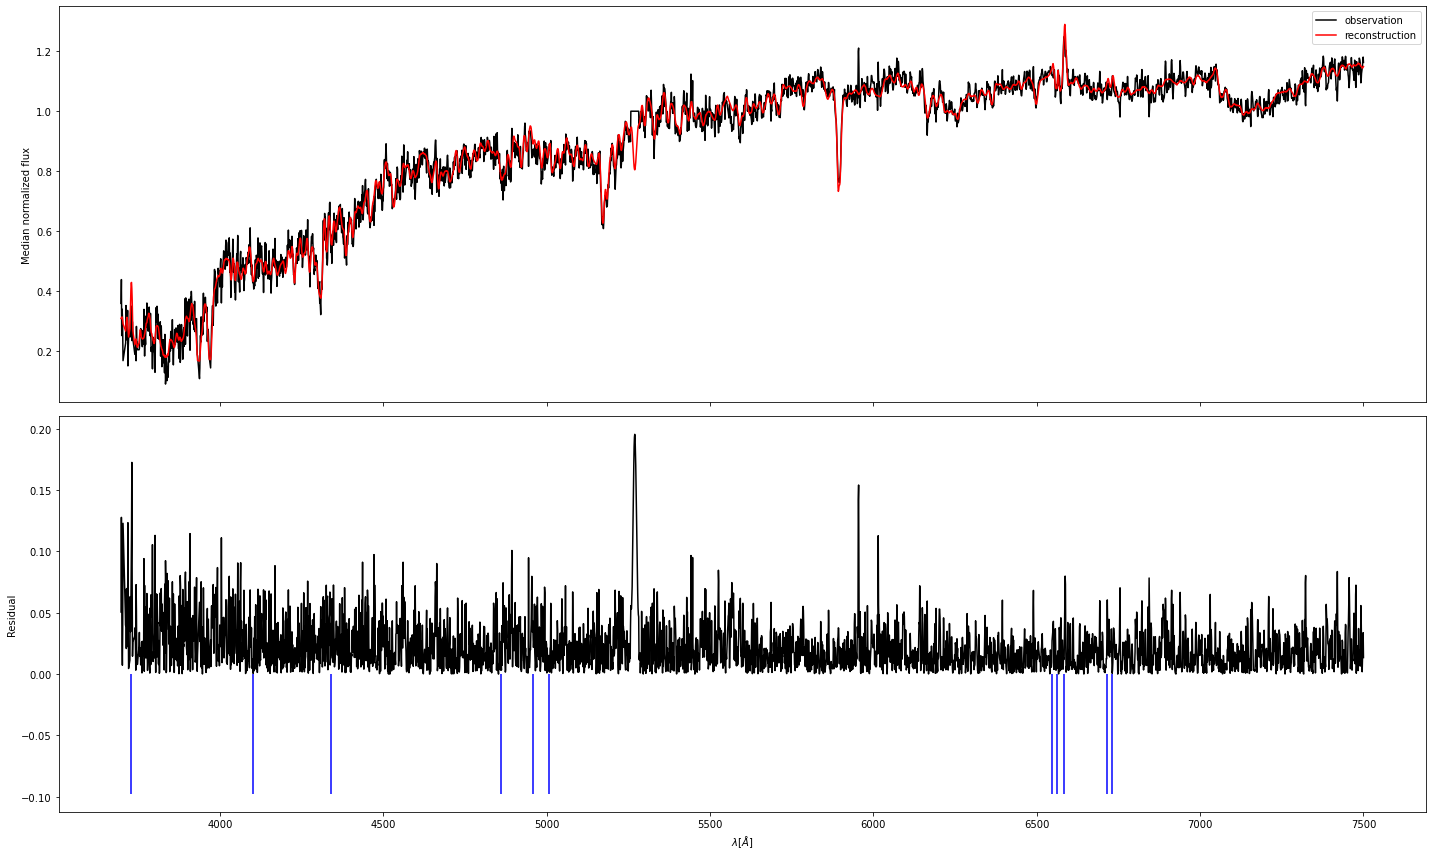

In [13]:
def plot_residual():
    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(20, 12),
        sharex=True,
        tight_layout=True,
    )

    axs[0].set_ylabel("Median normalized flux")
    axs[1].set_ylabel("Residual")
    axs[1].set_xlabel("$\lambda [\AA]$")

    return fig, axs


image_format = "jpg"

show_lines = True
fig, axs = plot_residual()

for score in scores_names.keys():
    save_to = f"/home/edgar/explain-me-why/sections/figures/score/{score}"

    if os.path.exists(save_to) is False:
        os.makedirs(save_to)

    for rank in range(1, 1001):

        specobjid = df_scores[score].index[-rank]
        idx = specobjid_to_idx(specobjid, ids)

        observation, reconstruction, residual = compare(idx)
        for ax in axs:
            ax.clear()
        axs[0].set_ylabel("Median normalized flux")
        axs[1].set_ylabel("Residual")
        axs[1].set_xlabel("$\lambda [\AA]$")

        axs[0].plot(wave, observation, c="black", label="observation")
        axs[0].plot(wave, reconstruction, c="red", label="reconstruction")
        axs[1].plot(wave, residual, c="black")

        axs[0].legend()

        if show_lines is True:
            for line in GALAXY_LINES:
                axs[1].vlines(
                    GALAXY_LINES[line],
                    ymin=0,
                    ymax=-residual.max() * 0.5,
                    color="blue",
                )

        fig.savefig(f"{save_to}/rank_{rank:03d}.{image_format}")

969534273977608192


/tmp/ipykernel_84889/48254846.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f"{save_to}/{plot_name}.jpg")
/tmp/ipykernel_84889/48254846.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f"{save_to}/{plot_name}.pdf")
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


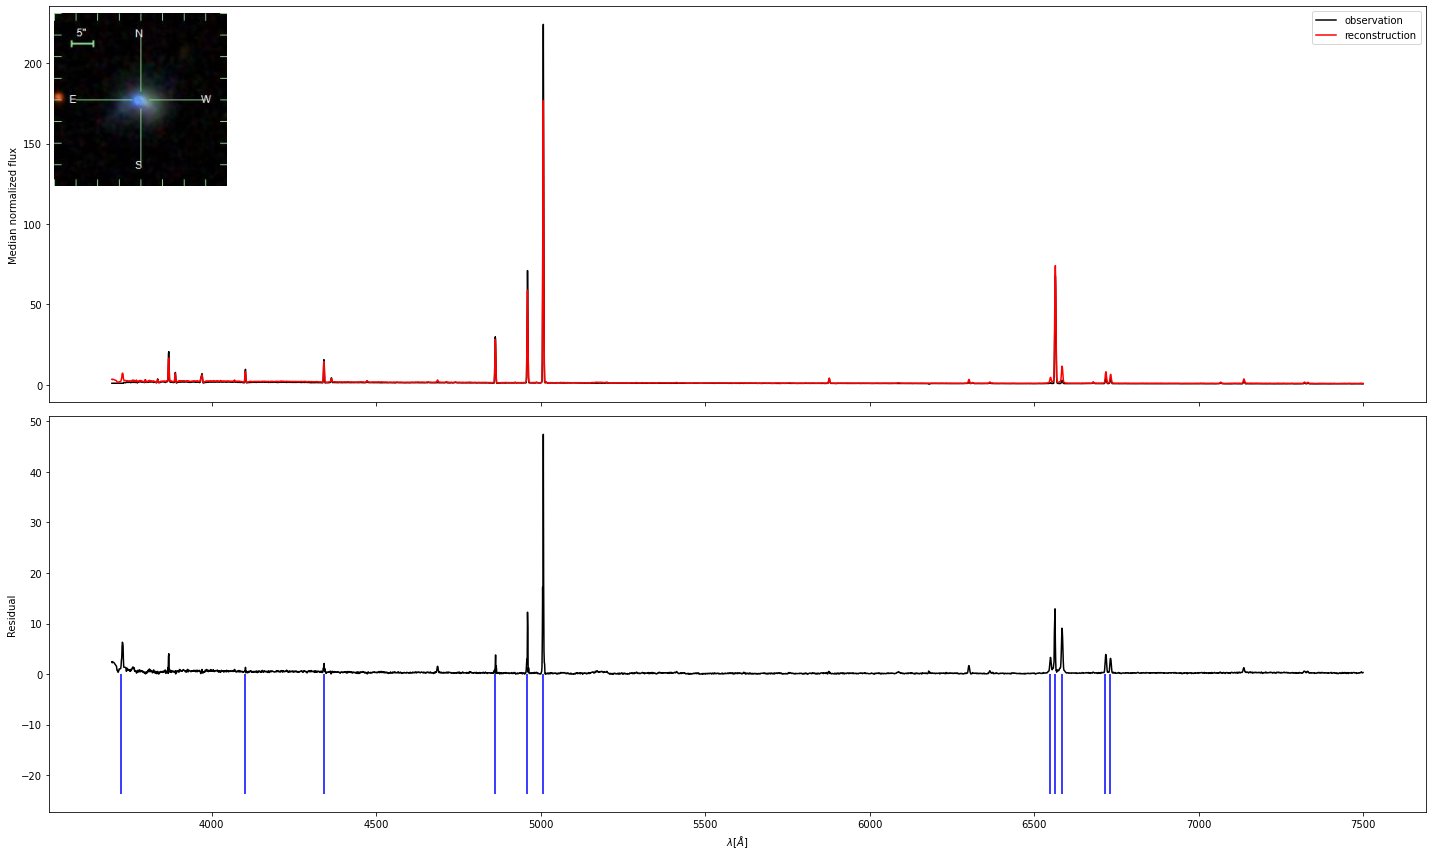

In [18]:
def plot_residual():
    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(20, 12),
        sharex=True,
        tight_layout=True,
    )

    axs[0].set_ylabel("Median normalized flux")
    axs[1].set_ylabel("Residual")
    axs[1].set_xlabel("$\lambda [\AA]$")

    return fig, axs


# score = "mse_noRel100"
score = "mse_filter_250kms_noRel100"
# score = "mse_noRel97"
# score = "mse_filter_250kms_noRel97"
save_to = f"/home/edgar/explain-me-why/sections/figures/score/{score}"

show_lines = True

rank = 12

fig, axs = plot_residual()

specobjid = df_scores[score].index[-rank]
print(specobjid)
idx = specobjid_to_idx(specobjid, ids)

observation, reconstruction, residual = compare(idx)
for ax in axs:
    ax.clear()
axs[0].set_ylabel("Median normalized flux")
axs[1].set_ylabel("Residual")
axs[1].set_xlabel("$\lambda [\AA]$")

axs[0].plot(wave, observation, c="black", label="observation")
axs[0].plot(wave, reconstruction, c="red", label="reconstruction")
axs[1].plot(wave, residual, c="black")

axs[0].legend()


if show_lines is True:
    for line in GALAXY_LINES:
        axs[1].vlines(
            GALAXY_LINES[line],
            ymin=0,
            ymax=-residual.max() * 0.5,
            color="blue",
        )
# Download sdss image
ra = df_scores[score].loc[specobjid, "ra"]
dec = df_scores[score].loc[specobjid, "dec"]
meta.get_sdss_image(
    specobjid=specobjid,
    coordinates=(ra, dec),
    save_to=save_to,
    image_format="pdf",
)

# plot image
galaxy_image = plt.imread(f"{save_to}/{specobjid}.pdf")
image_axis = fig.add_axes([0.0, 0.78, 0.2, 0.2])
image_axis.imshow(galaxy_image)
image_axis.axis("off")

plot_name = f"rank_{abs(rank):03d}"
fig.savefig(f"{save_to}/{plot_name}.jpg")
fig.savefig(f"{save_to}/{plot_name}.pdf")

In [19]:
meta.get_sky_server_url(969534273977608192)

'http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=969534273977608192&apid='

In [24]:
df_scores[score]["z"]

specobjid
933384530310490112     0.028070
948091324307892224     0.020937
3090681626930210816    0.058667
375080288679651328     0.152223
637281375052916736     0.096695
                         ...   
407586794930989056     0.050221
407595591024011264     0.101406
1413149843194406912    0.016985
378399434137954304     0.081500
407596690535639040     0.124473
Name: z, Length: 10000, dtype: float64

In [27]:
print(meta.get_sky_server_url(375080288679651328))

http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=375080288679651328&apid=
